In [29]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import scipy.misc
import cv2
import glob
import imageio
import numpy as np
# imageio.plugins.ffmpeg.download()

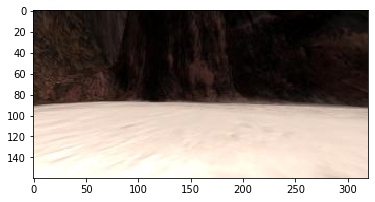

In [30]:
path = 'C:/Users/hp/Documents/Robotics/IMG/*'
img_list = glob.glob(path)

# grabing a random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

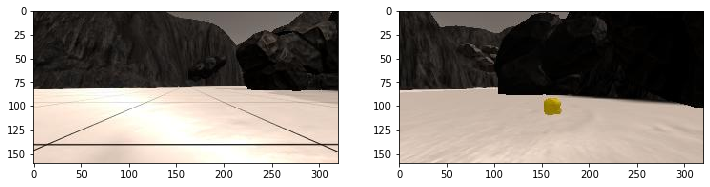

In [31]:
ex_rock = 'C:/Users/hp/Documents/Robotics/example_rock1.jpg'
ex_grid = 'grid1.jpg'
grid_img = mpimg.imread(ex_grid)
rock_img = mpimg.imread(ex_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

### Perspective transform

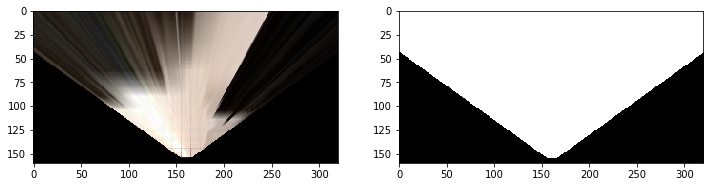

In [32]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    return warped, mask

dst_size = 5
bottom_offset = 6
source = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')

### Color thresholding

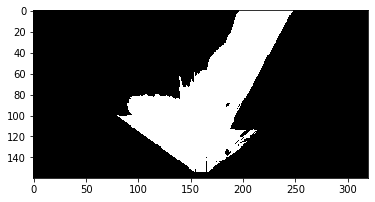

In [33]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0]) # creates an array of zero = to img[:,;,0]
    # find rgb > 0
    above_thresh = ((img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] > rgb_thresh[1]) & (img[:,:,2] > rgb_thresh[2])) 
    color_select[above_thresh] = 1 # converts the rgb>0 to 1
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

### Robot Coordinate

#### Rotation

* You'll accomplish this by applying a rotation matrix to your robot space pixel values (let's call them xpix and ypix). 
* For a rotation through an angle θ\theta, the operation looks like this:
 [x', y'] = [cosθ, sinθ - sinθ, cosθ] * [x, y]
 
 * x' = xcosθ - ysinθ
 * y' = xsinθ + ycosθ
 
##### - In code, you could write it up like this (passing in xpix and ypix as our original pixel positions and yaw as our yaw angle:

#### Translation 
* Perform a translation by simply adding the x and y components of the rover's position to the x_rotated and y_rotated values calculated above. 

##### Keep in mind, however, the scale associated with pixels in robot space versus world space.
* If, for example you have mapped pixels in rover space such that each represents 0.1 x 0.1 m, and in your world map (as will be the case in the project) each pixel is 1 x 1 m
* Then you need to divide your rover space pixel values by 10 before mapping to world space. 
* In that case, assuming the x and y position of the rover are given as xpos and ypos:

In [35]:
def robot_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover 
    # position being at the center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) - (ypix * np.cos(yaw_rad))
    # Apply a rotation
    ypix_rotated = 0
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# grabing a random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in robot-centric coords and distance/angle to all pixels
xpix, ypix = robot_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
def find_rocks (img, levels=(110, 110,50)):
    rockpix = ((img[:,:,0] > levels[0]) & (img[:,:,1] > levels[1])  & (img[:,:,2] < levels[2]))
    color_select = np.zeros_like(img[:,:,0])
    color_select[rockpix] = 1
    return color_select

rock_map = find_rocks(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

### Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell. 

In [ ]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('C:/Users/hp/Documents/Robotics/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('C:/Users/hp/Documents/Robotics/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to the process_image()function below
data = Databucket()

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  


To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [ ]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
# Example of how to use the Databucket() object defined abov
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)

In [ ]:
def process_image(img):
    warped,mask = perspect_transform(img, source, destination)
    threshed = color_thresh(warped)
    obs_map = np.absolute(np.float32(threshed) - 1) * 1
    xpix, ypix = robot_coords(threshed)
    world_size = data.worldmap.shape[0]
    scale = 2 * dst_size
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    obsxpix, obsypix = robot_coords(obs_map)
    obs_x_world, obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos, yaw, world_size, scale)
    
    data.worldmap[y_world, x_world, 2] = 255
    data.worldmap[obs_y_world, obs_x_world, 0] = 255
    nav_pix = data.worldmap[:,:,2] > 0
    
    rock_map = find_rocks(warped, levels=(110, 110, 50))
    if rock_map.any():
        rock_x, rock_y = robot_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos, yaw, world_size, scale)
        data,worldmap[rock_y_world, rock_x_world, :] =255
    
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

#### Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = 'C:/Users/hp/Documents/Robotics/mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

In [ ]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))